<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>


<br> <a href="3_SRAL_Tracks.ipynb">3 - SRAL tracks</a><span style="float:right;"><a href="./5_SRAL_Waveforms.ipynb">5 - SRAL waveforms >></a>  

## Compute corrected sea surface heights & anomalies from Sentinel-3 ##

Here we are going to do something fundamental with our altimetry data; calculating sea surface height from range and satellite altitude, and performing the relevant atmospheric, tidal and geoid corrections. Athough, sea surface height anomaly (SSHA) is provided within the data file we will also calculate it, for our interest.

### Import libraries and define input data

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import dates
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()
matplotlib.rcParams.update({'font.size': 16})

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [4]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
MYPATH=os.getcwd()

### Define our input data

In [5]:
input_root = os.path.join(MYPATH,'sral_data')
input_path = 'S3B_SR_2_WAT____20210601T105631_20210601T114338_20210627T032723_2827_053_094______MAR_O_NT_004.SEN3'
input_file = 'standard_measurement.nc'
#input_file = 'reduced_measurement.nc'
#input_file = 'enhanced_measurement.nc'
my_file    = os.path.join(input_root,input_path,input_file)
nc = xr.open_dataset(my_file)

These are the variables we are going to use:

NB. corrected sea surface height =
                                  Altitude 
                                  - range
                                  - atmosphere propagation corrections (dry/wet troposphere, ionosphere electrons)
                                  - tides (ocean, solid earth and pole)
                                  - atmospheric loading (pressure & hf winds)
                                  - sea state bias

then, depending on the reference you want to work with respect to, you can also remove either mean sea surface (to get sea level anomalies; SLAs) or the geoid (to get absolute dynamic topography; ADT), or nothing (to get SSH with respect to the ellipsoid).  For ADT, you can also add the mean topography instead of removing the geoid.

Below we define the variables we need to compute a corrected sea surface height and anomalies. The computation here is done with 1 Hz data with corrections dedicated to open ocean; "plrm" variables from a dedicated processing which mimics the conventional altimetry are proposed, but if you use them, use them systematically whenever available. DO NOT MIX PLRM WITH NON PRLM.

Over coastal areas some correction fields would be different, such as the wet tropospheric correction (not from radiometer). Some corrections are only provided at 1Hz, since their resolution can't be higher, but they still must be applied for a computation at 20 Hz, though. So you have to use 20 times the 1 Hz value. 

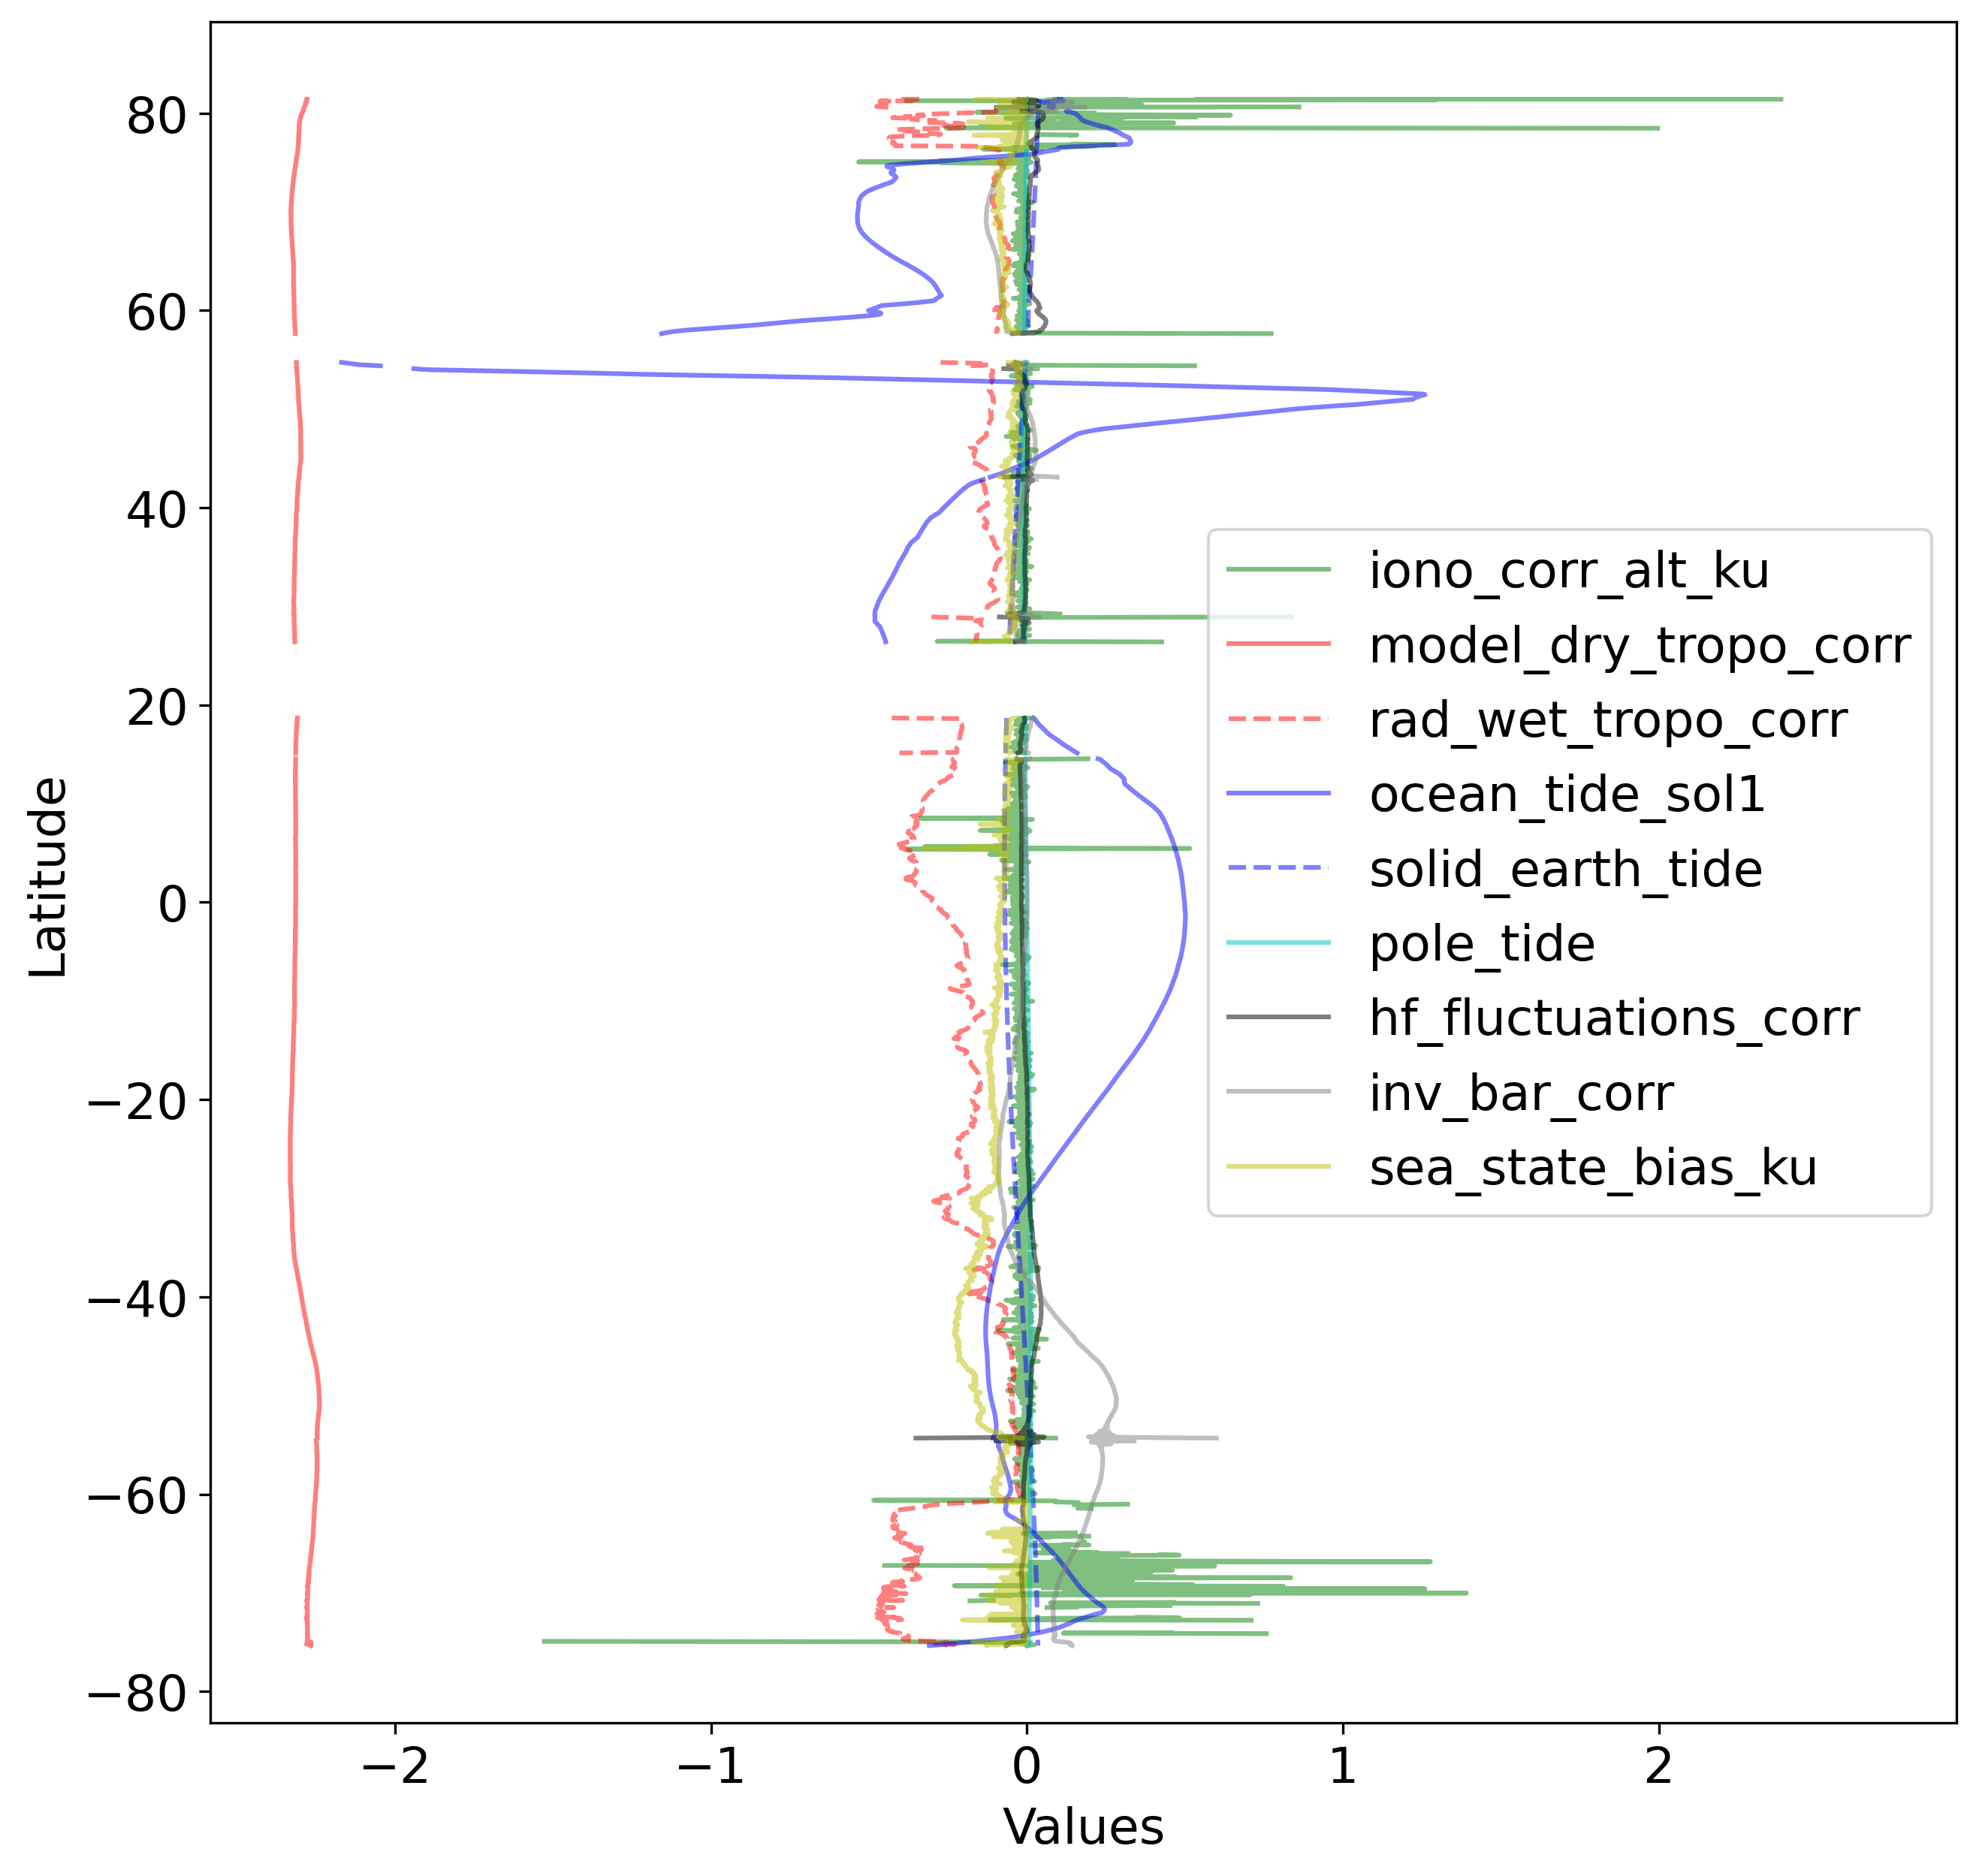

In [6]:
lat = nc.variables['lat_01'][:]
lon = nc.variables['lon_01'][:]
range_ku = nc.variables['range_ocean_01_ku'][:]
alt = nc.variables['alt_01'][:]
#atmosphere propagation corrections
model_dry_tropo_corr = nc.variables['mod_dry_tropo_cor_meas_altitude_01'][:]
rad_wet_tropo_corr = nc.variables['rad_wet_tropo_cor_01_ku'][:]
iono_corr_alt_ku = nc.variables['iono_cor_alt_01_ku'][:]
#tides
ocean_tide_sol1 = nc.variables['ocean_tide_sol1_01'][:]
solid_earth_tide = nc.variables['solid_earth_tide_01'][:]
pole_tide = nc.variables['pole_tide_01'][:]
#atmospheric loading, sea state bias
hf_fluctuations_corr = nc.variables['hf_fluct_cor_01'][:]
inv_bar_corr = nc.variables['inv_bar_cor_01'][:]
sea_state_bias_ku = nc.variables['sea_state_bias_01_ku'][:]
#reference surfaces
mean_sea_surface = nc.variables['mean_sea_surf_sol1_01'][:]
mean_topography = nc.variables['mean_dyn_topo_01'] [:]
geoid = nc.variables['geoid_01'] [:]
# surface class flag
surf_class_01 = nc.variables['surf_class_01'][:]
surface_type = nc.variables['surf_type_01'][:]

# geophysical variables
swh_ku = nc.variables['swh_ocean_01_ku'][:]
sig0_ku = nc.variables['sig0_ocean_01_ku'][:]
wind_speed_alt = nc.variables['wind_speed_alt_01_ku'][:]

nc.close()

alph = 0.5

# flag out non-ocean values
alt[surface_type != 0.0] = np.nan
range_ku[surface_type != 0.0] = np.nan

iono_corr_alt_ku[surface_type != 0.0] = np.nan
model_dry_tropo_corr[surface_type != 0.0] = np.nan
rad_wet_tropo_corr[surface_type != 0.0] = np.nan
ocean_tide_sol1[surface_type != 0.0] = np.nan
solid_earth_tide[surface_type != 0.0] = np.nan
pole_tide[surface_type != 0.0] = np.nan
hf_fluctuations_corr[surface_type != 0.0] = np.nan
inv_bar_corr[surface_type != 0.0] = np.nan
sea_state_bias_ku[surface_type != 0.0] = np.nan

#visualize the variables above
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
p1, = ax.plot(iono_corr_alt_ku, lat, 'g', label='iono_corr_alt_ku', alpha=alph)
p2, = ax.plot(model_dry_tropo_corr, lat, 'r', label='model_dry_tropo_corr', alpha=alph)
p3, = ax.plot(rad_wet_tropo_corr, lat, 'r--', label='rad_wet_tropo_corr', alpha=alph)
p4, = ax.plot(ocean_tide_sol1, lat, 'b', label='ocean_tide_sol1', alpha=alph)
p5, = ax.plot(solid_earth_tide, lat,  'b--', label='solid_earth_tide', alpha=alph)
p6, = ax.plot(pole_tide, lat, 'c', label='pole_tide', alpha=alph)
p7, = ax.plot(hf_fluctuations_corr, lat, 'k', label='hf_fluctuations_corr', alpha=alph)
p8, = ax.plot(inv_bar_corr, lat, '0.5', label='inv_bar_corr', alpha=alph)
p9, = ax.plot(sea_state_bias_ku, lat, 'y', label='sea_state_bias_ku', alpha=alph)

plt.xlabel('Values', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.savefig('SRAL_SSH_calculation_corrections')

plt.show()

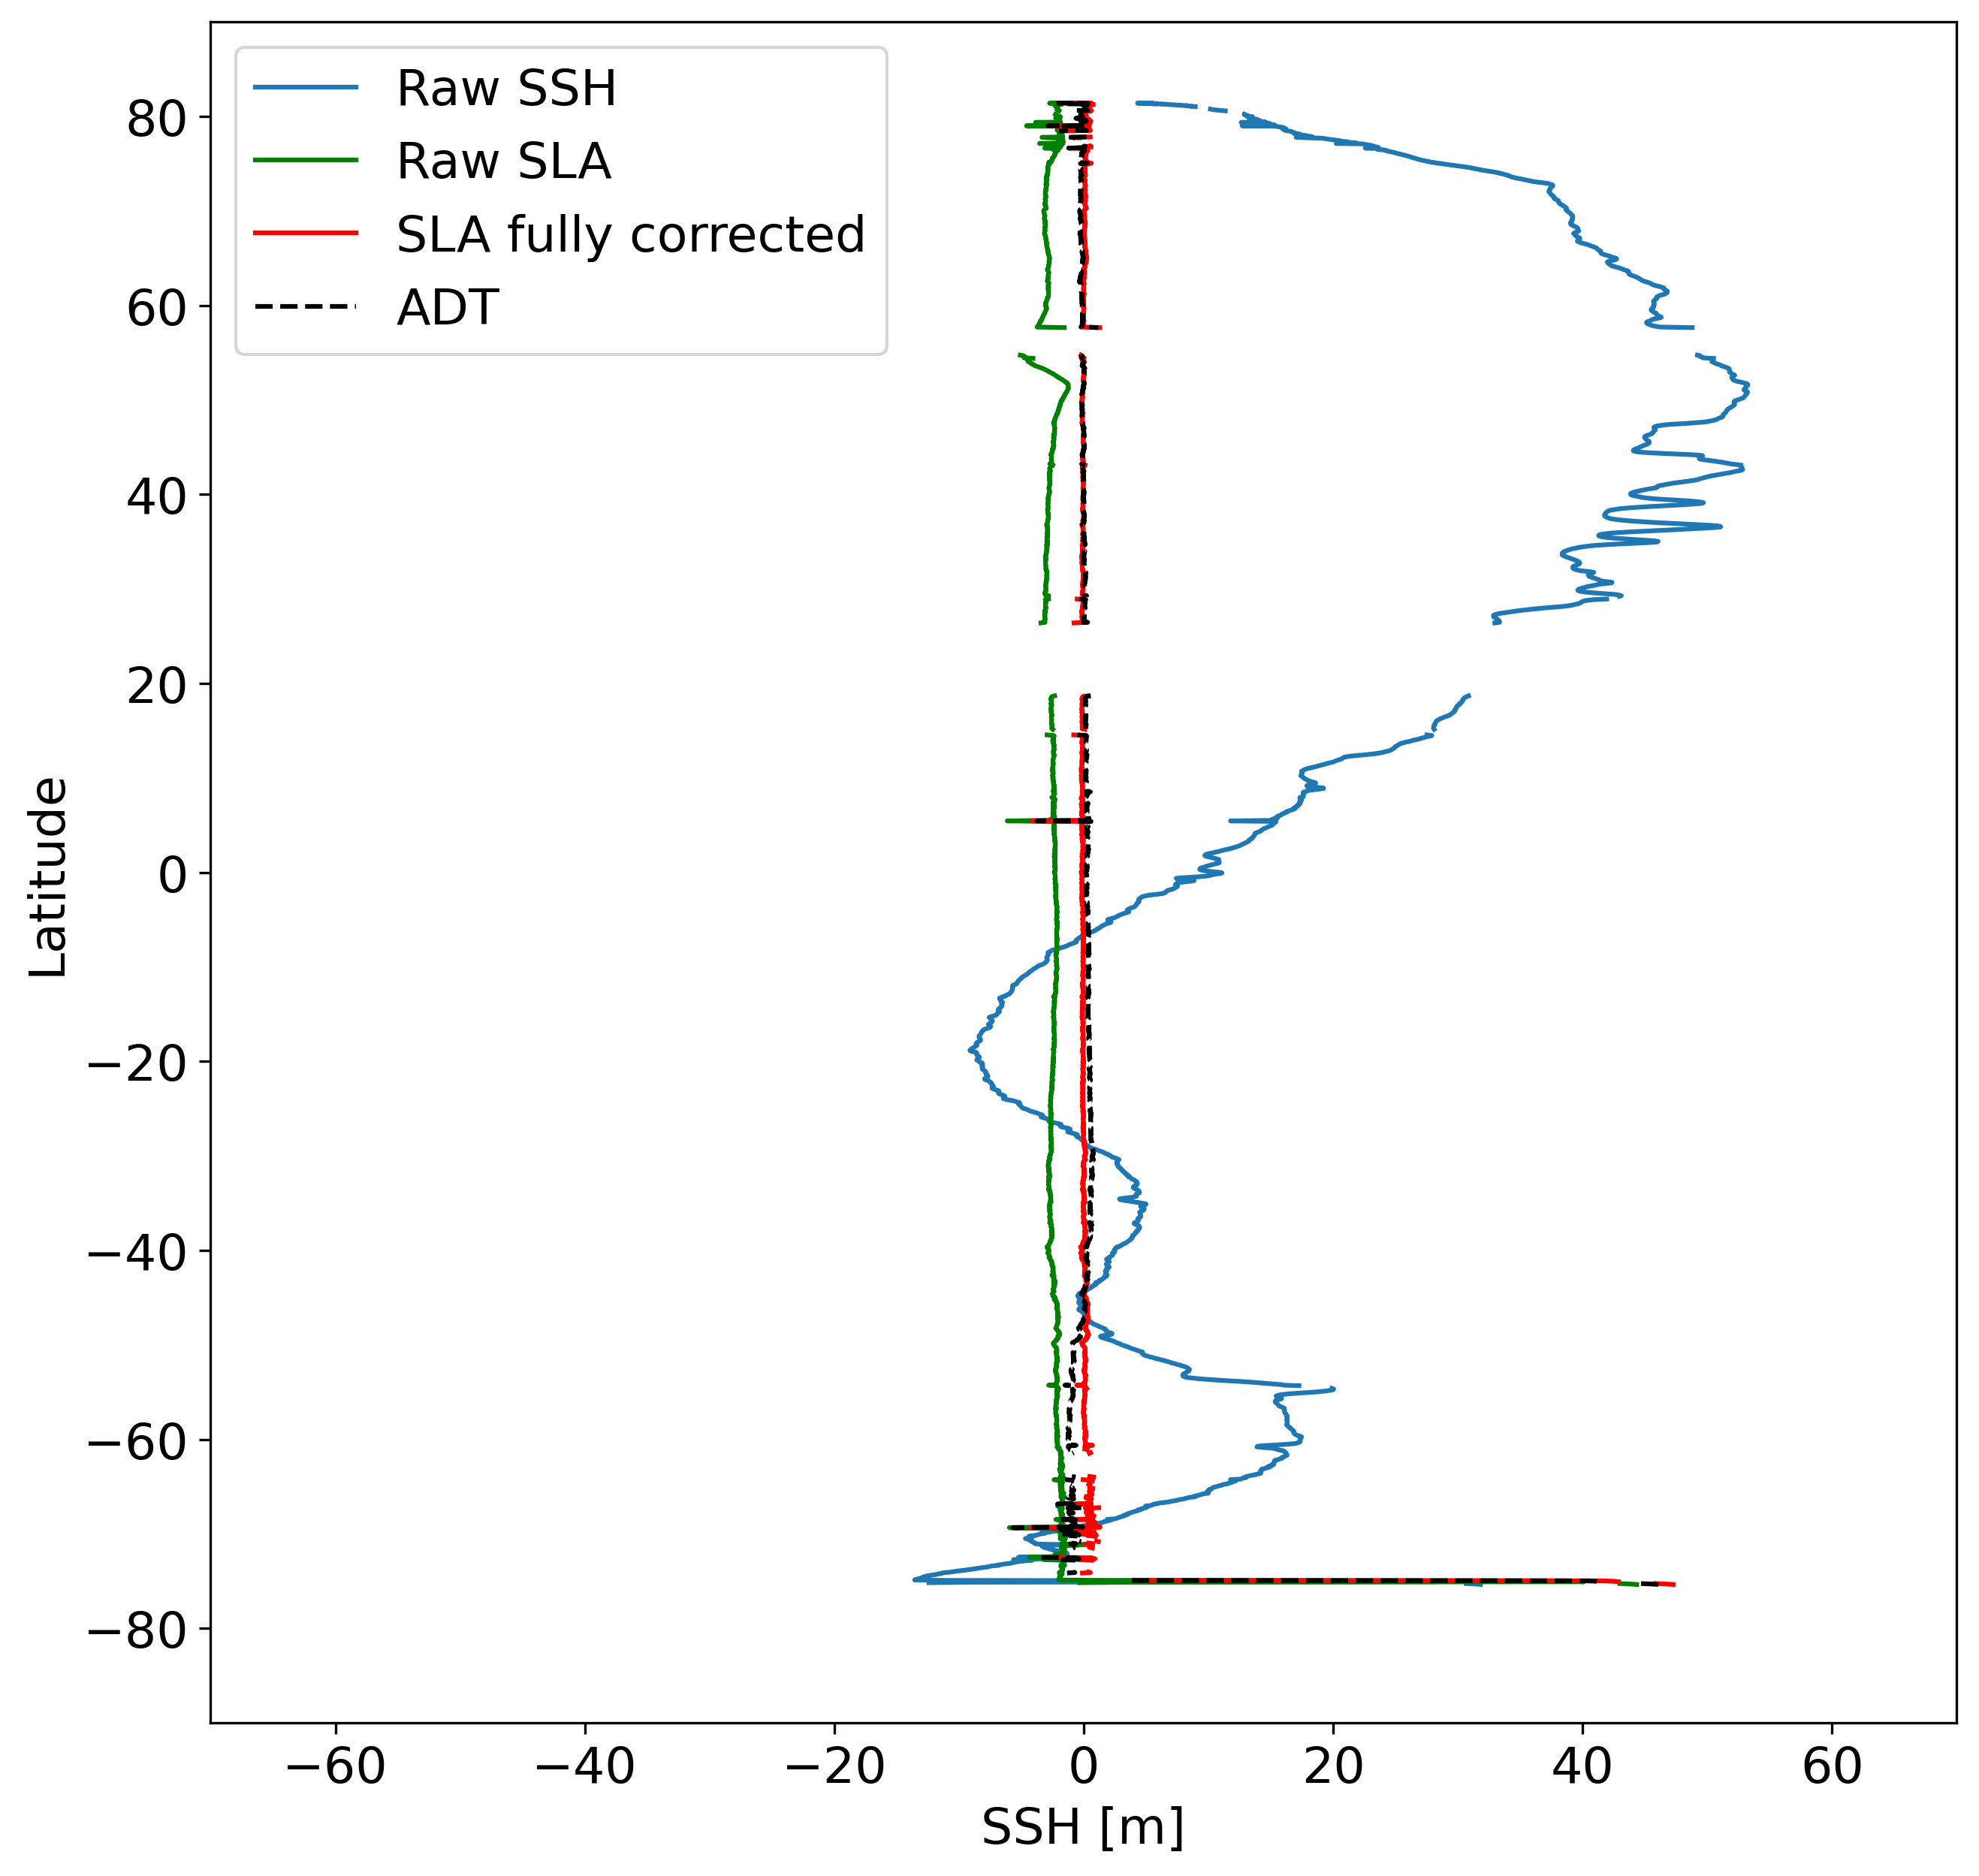

In [7]:
# here are intermediate computation steps of ssh and sla (though there is no order to apply the corrections)
# usually, only the full corrected ones are used, except if e.g. some need to be replaced by local equivalents
# the idea here is that you get a concrete idea of the impact of each of them
raw_ssh = alt - range_ku
raw_sla = (alt - range_ku) - mean_sea_surface
sla_ionocorr = ((alt - range_ku) - mean_sea_surface) - iono_corr_alt_ku
sla_iono_drytropocorr = sla_ionocorr - model_dry_tropo_corr
sla_iono_radtropocorr = sla_iono_drytropocorr - rad_wet_tropo_corr
tides = (ocean_tide_sol1 - solid_earth_tide) - pole_tide
sla_iono_tropo_tides_corr = sla_iono_radtropocorr - tides
sla_iono_tropo_tides_ssb_corr = sla_iono_tropo_tides_corr - sea_state_bias_ku
dynatmcorr = hf_fluctuations_corr + inv_bar_corr
sla_fullcorr = sla_iono_tropo_tides_ssb_corr - dynatmcorr
adt = sla_fullcorr + mean_topography

#plot e.g. a "raw" version of SSH (un-corrected) and the corrected SLA
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
p1, = ax.plot(raw_ssh, lat, label='Raw SSH')
p2, = ax.plot(raw_sla, lat, 'g', label='Raw SLA')
p3, = ax.plot(sla_fullcorr, lat, 'r', label='SLA fully corrected')
p4, = ax.plot(adt, lat, 'k--', label='ADT')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.axis([-70, 70, -90, 90])
plt.xlabel('SSH [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show()


Note the amplitude of the SSH, and note also the very extreme SSH data (not present in the corrected SLA)

## Looking at a major current ##

the graph above shows a whole track (half orbit); a smaller area can be easier to interpret. We will focus on the North Atlantic (Gulf Stream), i.e. restrict the graph to a latitude between 0 and 45°N. 
You may need to adapt the axis to the area/date you are looking at. Zoom over another region and look at the extrema values

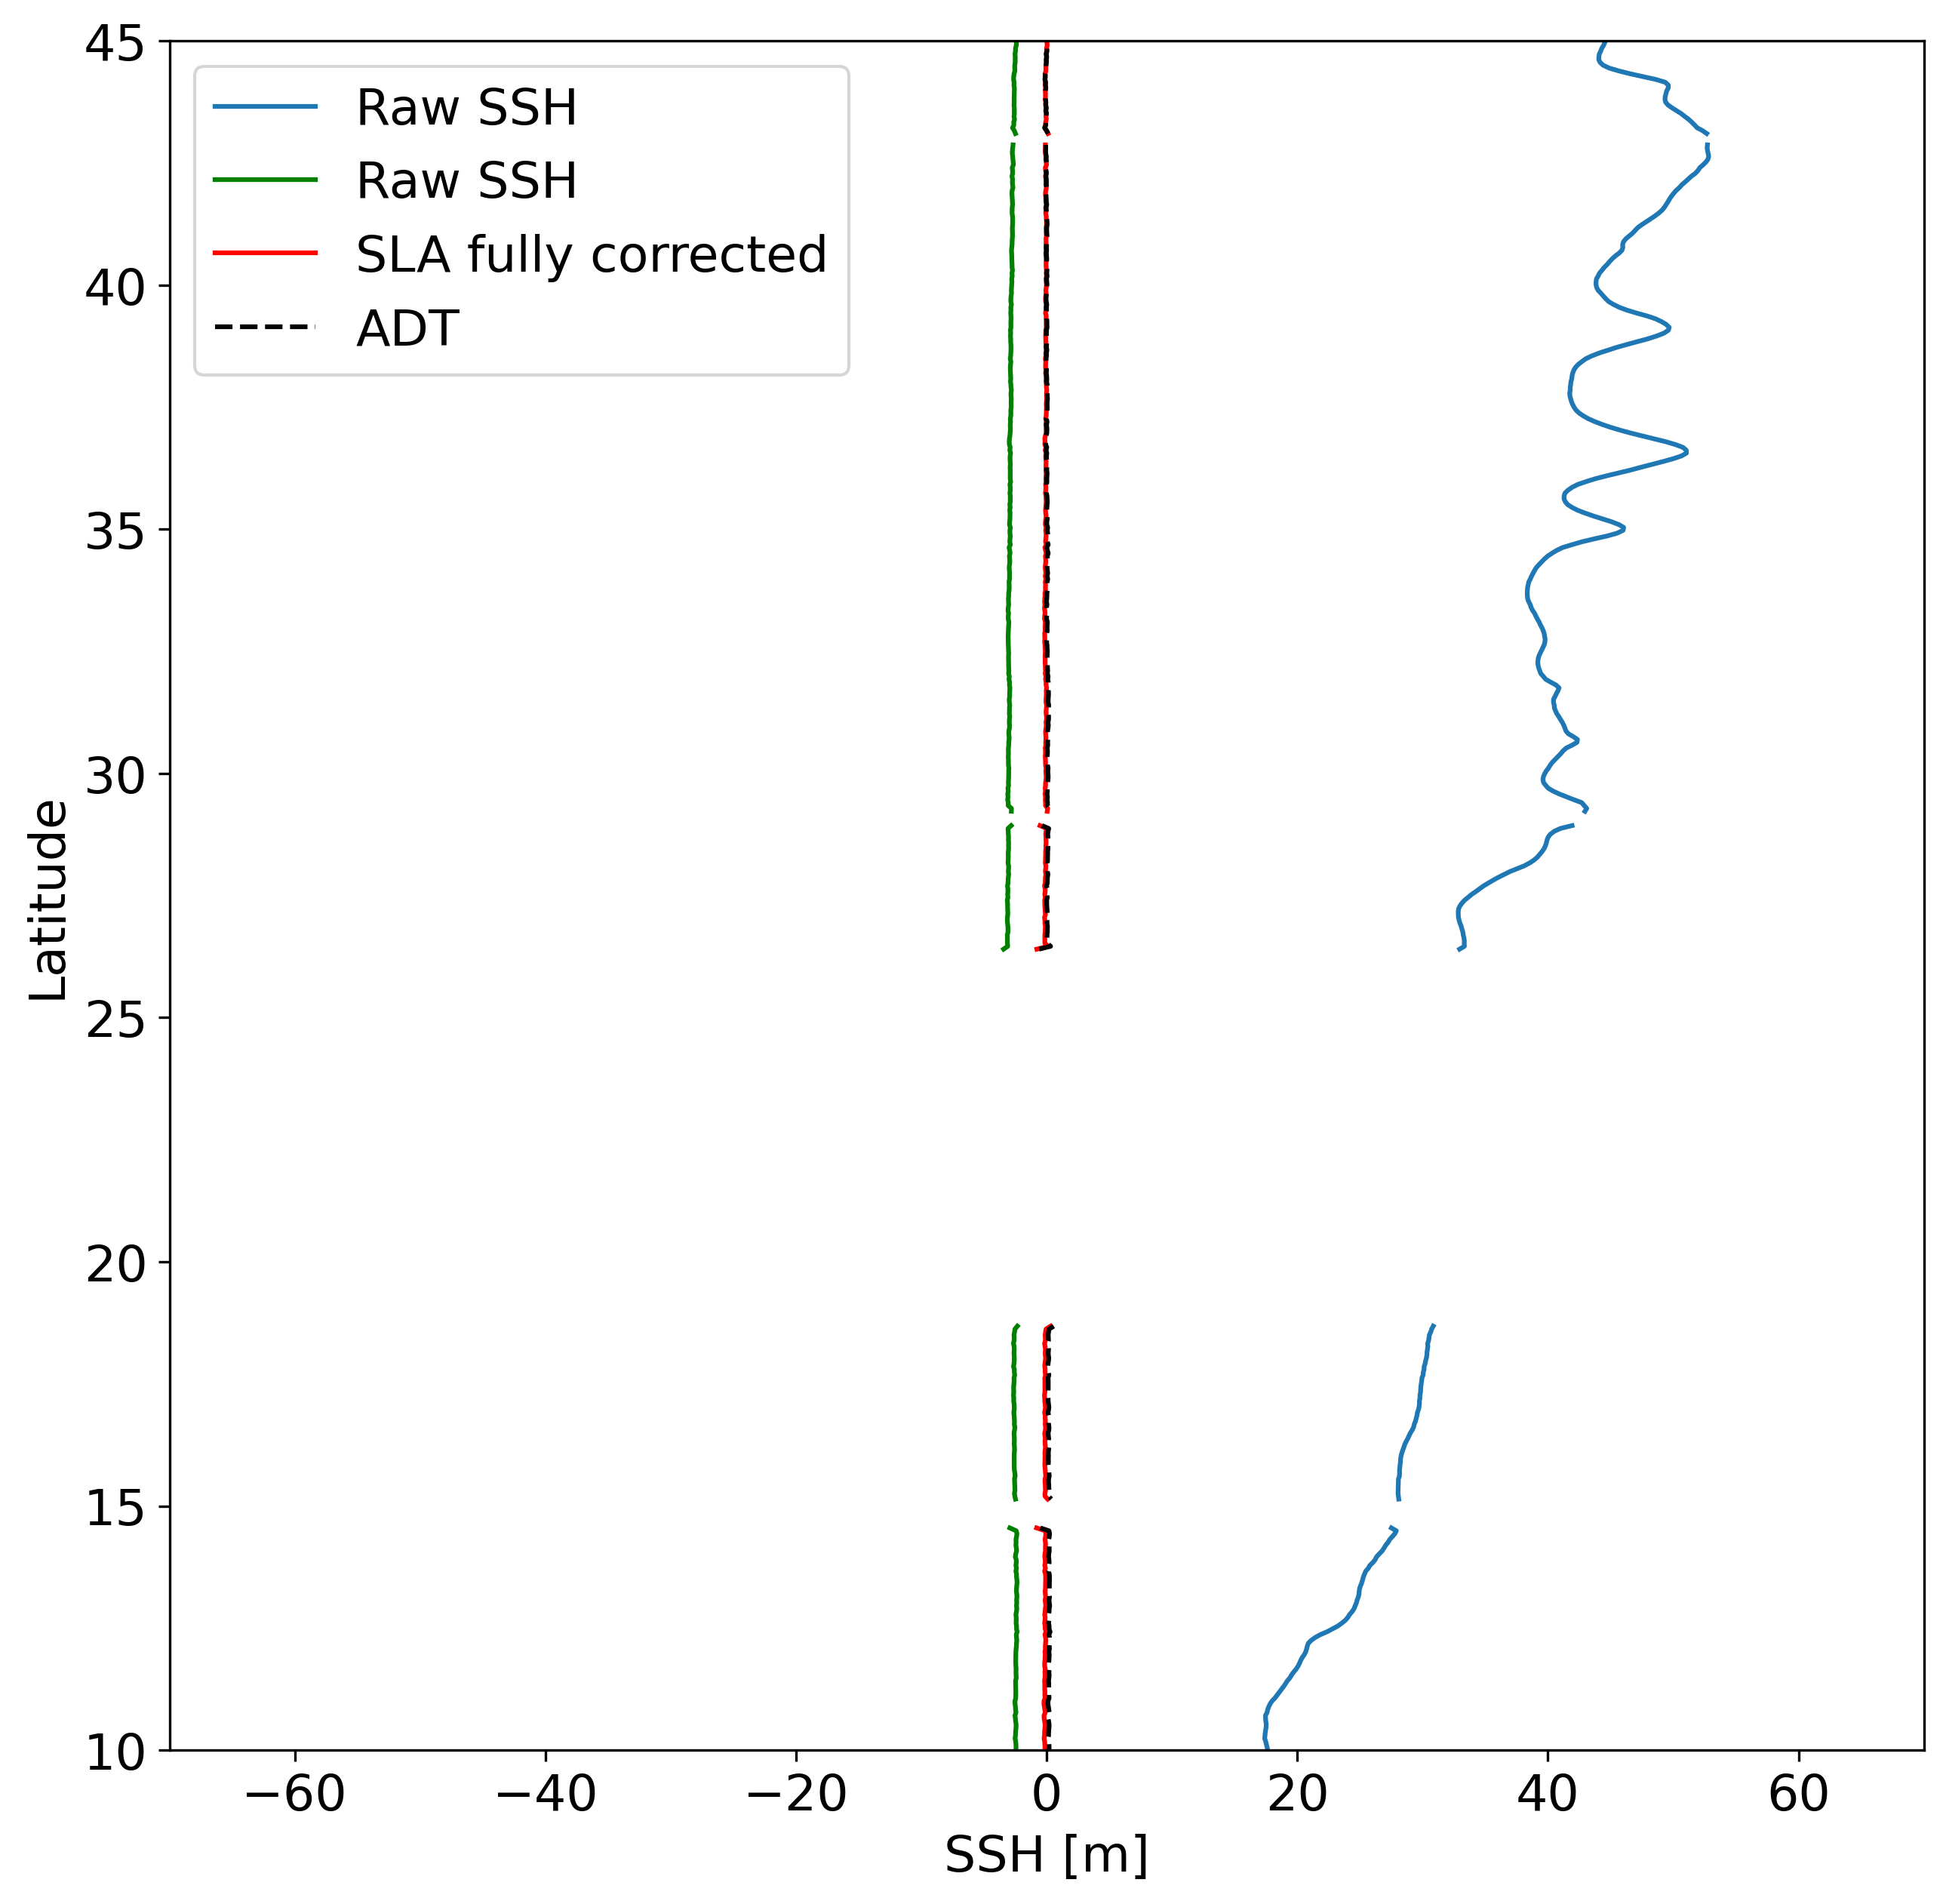

In [8]:
# zoom on an area and adapt the scale 
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
p1, = ax.plot(raw_ssh, lat, label='Raw SSH')
p2, = ax.plot(raw_sla, lat, 'g', label='Raw SSH')
p3, = ax.plot(sla_fullcorr, lat, 'r', label='SLA fully corrected')
p4, = ax.plot(adt, lat, 'k--', label='ADT')
# modify the third and fourth values below to adapt the y scale (NB. we are working in meters, for raw ssh)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.axis([-70, 70, 10, 45])
plt.xlabel('SSH [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show()

## Tests on the variables over the Gulf Stream area ##

Try and test different variables as defined above - corrections and intermediate ssh values
modify the min/max value to better see the amplitude of the curves ends up with sla_fullcorr

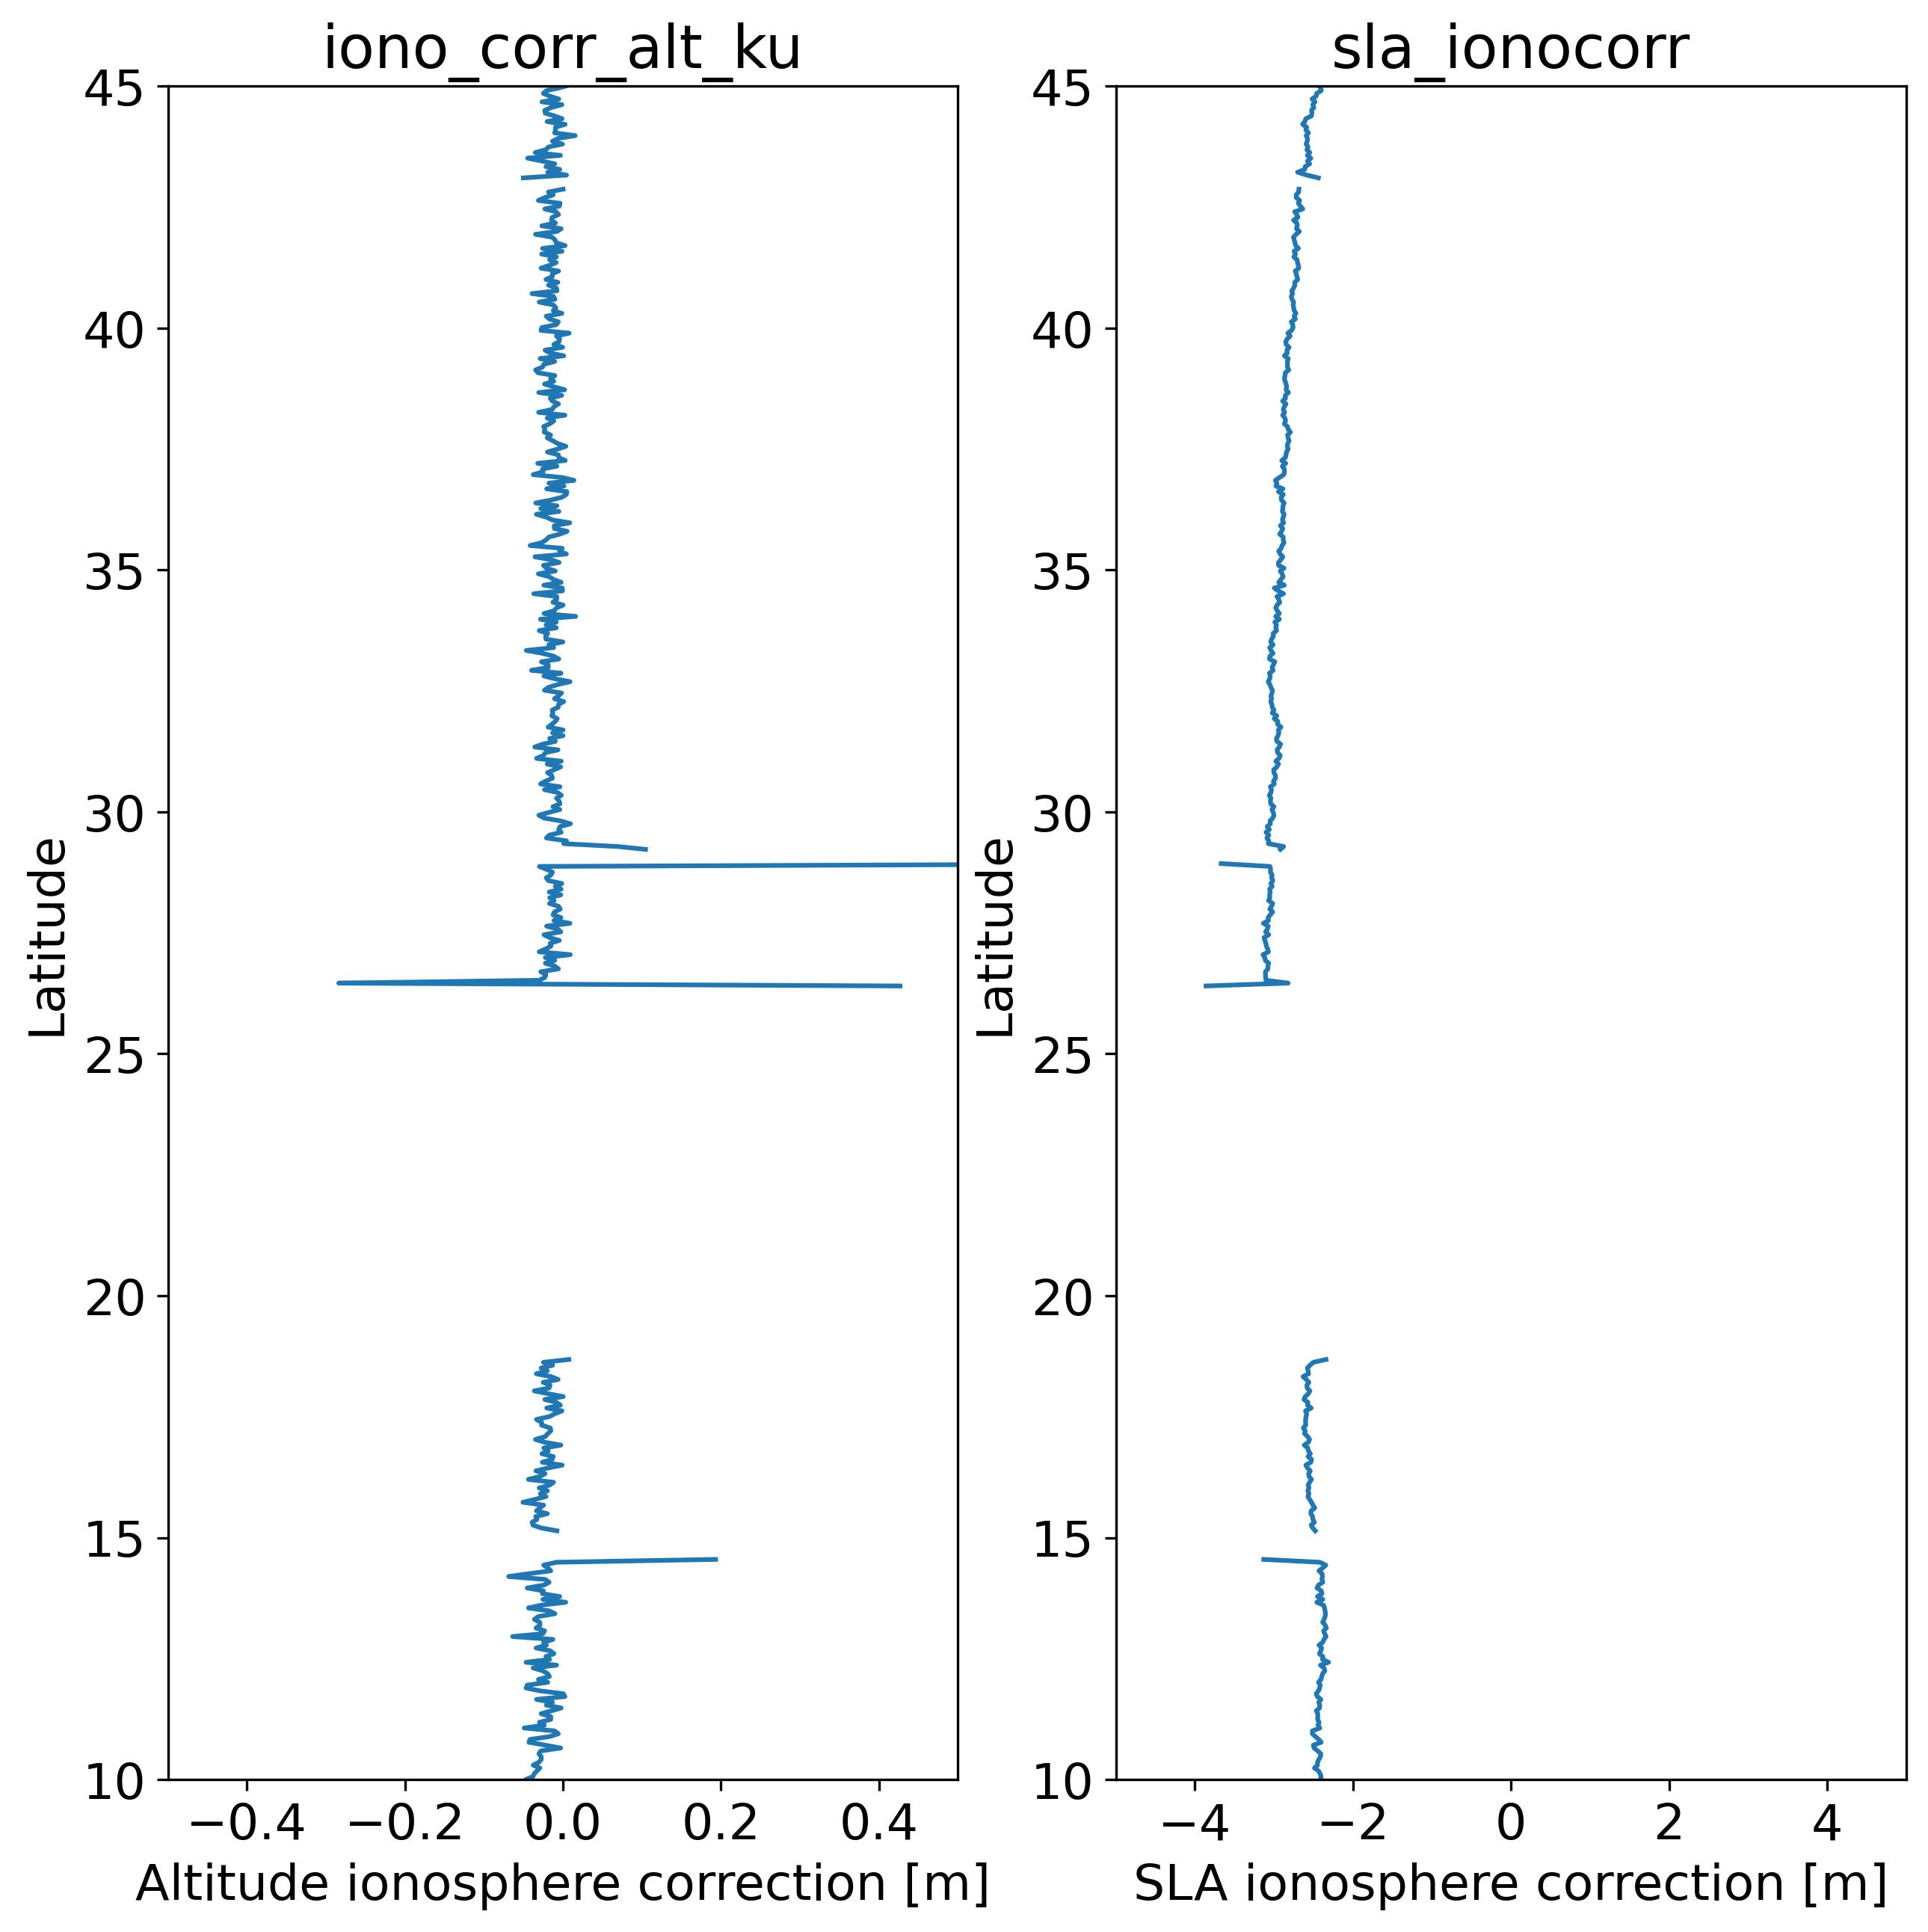

In [10]:
fig1 = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,2,1)
p1 = ax.plot(iono_corr_alt_ku, lat)
plt.title('iono_corr_alt_ku')
plt.xlabel('Altitude ionosphere correction [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.axis([-0.5, 0.5, 10, 45])
ax = plt.subplot(1,2,2)
ax.plot(sla_ionocorr, lat)
plt.title('sla_ionocorr')
plt.xlabel('SLA ionosphere correction [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.axis([-5, 5, 10, 45])
plt.show()

You can apply the computation to a whole cycle or a regional area of a whole cycle and map it.
Note that if you mix SLA computed like this from several satellites (e.g. from Jason-3), you will have biases and other differences between them.

<br> <a href="3_SRAL_Tracks.ipynb">3 - SRAL tracks</a><span style="float:right;"><a href="./5_SRAL_Waveforms.ipynb">5 - SRAL waveforms >></a>  
    
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>